In [32]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

<font style="font-size:28px;" align="center"><b> Simulating the one-dimensional Harmonic Oscillator with VQE using IBM Qiskit </b></font>

The Variational Quantum Eigensolver (VQE) is an algorithm used for finding the ground state energy, i.e lowest energy, of a molecule.
In this work, we simulate the ground state of the one-dimensional Harmonic Oscillator with the VQE algorithm run on IBM Qiskit. 

The matrix of eigenvalues (energies) of the one-dimensional Harmonic Oscillator is represented by:

$$
E = \frac{\hbar \omega}{2}\begin{pmatrix}
                           1 & 0 & 0 & 0 & ...\\
                           0 & 3 & 0 & 0 & ...\\
                           0 & 0 & 5 & 0 & ...\\
                           0 & 0 & 0 & 7 & ...\\
                           . & . & . & . & ...\\
                           . &  . & . & . & ...\\
                           \end{pmatrix}
$$

Using this matrix, we aim to determine the ground state of the Harmonic Oscillator.

<h1> 1. Hamiltonian Decomposition </h1>

In [33]:
""" Hamiltonian of the ground state and the 3 higher energy levels of the one-dimensional 
    Harmonic Oscillator"""

import numpy as np
ho_hamiltonian = np.array([[0.5,0,0,0],
                           [0,1.5,0,0],
                           [0,0,2.5,0],
                           [0,0,0,3.5]])

Hamiltonians for spin-systems can be decomposed in a sum of the tensor product of Pauli-matrices using the Schmidt Decomposition.  

For a two-qubit Hamiltonian given as an explicit 4×4 matrix, the Pauli-matrix decomposition is:

$$\sum_{i,j=1,x,y,z} a_{i,j}(\sigma_{i}\otimes\sigma_{j})$$

$$ a_{i,j} = \frac{1}{4}tr[(\sigma_{i}\otimes\sigma_{j})H] $$

In [34]:
def HS(M1, M2):
    """Hilbert-Schmidt-Product of two matrices M1, M2"""
    return (np.dot(M1.conjugate().transpose(), M2)).trace()

def complex_num(c):
    """Return a string representation of a complex number c"""
    if c == 0.0:
        return "0"
    if c.imag == 0:
        return "%g" % c.real
    elif c.real == 0:
        return "%gj" % c.imag
    else:
        return "%g+%gj" % (c.real, c.imag)
    
def decompose(H):
    """Decompose Hermitian 4x4 matrix H into Pauli matrices"""
    from numpy import kron
    sx = np.array([[0, 1],  [ 1, 0]])
    sy = np.array([[0, -1j],[1j, 0]])
    sz = np.array([[1, 0],  [0, -1]])
    id = np.array([[1, 0],  [ 0, 1]])
    
    P = [id, sx, sy, sz]
    
    Pauli_matrices = ['I', 'sigma_x', 'sigma_y', 'sigma_z']
    
    for i in range(len(H)):
        for j in range(len(H)):
            PM = Pauli_matrices[i] + ' TENSOR ' + Pauli_matrices[j]
            a_ij = 0.25 * HS(kron(P[i], P[j]), H)
            if a_ij != 0.0:
                print ("%s\t*\t( %s )" % (complex_num(a_ij), PM))

In [35]:
""" Decomposition of the hamiltonian matrix into a sum of tensor products of Pauli matrices"""
ho_decomposed = decompose(ho_hamiltonian)

2	*	( I TENSOR I )
-0.5	*	( I TENSOR sigma_z )
-1	*	( sigma_z TENSOR I )


<h1> 2. Running VQE on the Statevector simulator </h1>

We run VQE algorithm to compute the minimum eigenvalue of the one-dimensional Harmonic Oscillator.
Theoretically, the minimum eigenvalue is <span style="color: red;"><b>0.5</b></span>.
<b>The aim of this work is to verify this result by running Qiskit VQE on the Statevector simulator and the IBM quantum device.</b>

In [36]:
from qiskit import BasicAer
from qiskit.aqua.operators import Z, I
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import VQE
from qiskit.aqua.components.initial_states import Zero
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal

<h3> 1. The decomposed hamiltonian in terms of a sum of tensor products of Pauli matrices </h3>

In [37]:
ho_decomposed_expression = (2 * I ^ I) + \
                     (-0.5 * I ^ Z) + \
                     (-1 * Z ^ I) 

<h3> 2. The ansatz </h3>

In [38]:
var_form = TwoLocal(rotation_blocks=['ry'], entanglement_blocks='cx')

counts = []
values = []

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

<h3> 3. The optimizer </h3>

In [39]:
optimizer = COBYLA(maxiter=500)
converge_cnts = np.empty([1], dtype=object)
converge_vals = np.empty([1], dtype=object)

print('Optimizer {}'.format(type(optimizer).__name__), end='')
aqua_globals.random_seed = 50

Optimizer COBYLA

<h3> 4. Running VQE on Statevector simulator </h3>

In [40]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

vqe = VQE(ho_decomposed_expression, var_form, optimizer, callback=store_intermediate_result,
          quantum_instance=QuantumInstance(backend=BasicAer.get_backend('statevector_simulator')))

result = vqe.compute_minimum_eigenvalue(operator=ho_decomposed_expression)
converge_cnts = np.asarray(counts)
converge_vals = np.asarray(values)
print('Optimization complete')

Optimization complete


The minimum eigenvalue solved with COBYLA optmizer is  0.5000000036709741
rounded to  0.5


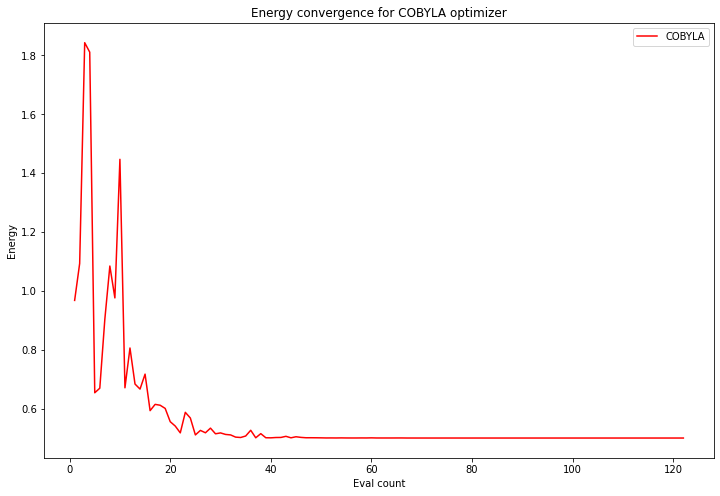

In [41]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 8)
plt.plot(converge_cnts, converge_vals, label=type(optimizer).__name__, color='red')
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Energy convergence for COBYLA optimizer')
plt.legend(loc='upper right');
ax = plt.gca()
line = ax.lines[0]

print("The minimum eigenvalue solved with COBYLA optmizer is ", min(line.get_ydata()))
print("rounded to ", round(min(line.get_ydata()), 2))

<h1> 3. Running VQE on noisy IBM Quantum Device model </h1>

In [42]:
from qiskit.aqua.algorithms import VQE, NumPyEigensolver

from qiskit import IBMQ, BasicAer, Aer

from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

<h3> 1. Mapping the hamiltonian to the noisy quantum device model </h3>

In [43]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_lima")

coupling_map = device.configuration().coupling_map

noise_model = NoiseModel.from_backend(device.properties())

quantum_instance = QuantumInstance(backend=backend, 
                                   shots=8192, 
                                   noise_model=noise_model, 
                                   coupling_map=coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)

ibmqfactory.load_account:WARNING:2021-11-19 12:35:14,356: Credentials are already in use. The existing account in the session will be replaced.


<h3> 2. The Ansatz </h3>

In [44]:
var_form = TwoLocal(rotation_blocks=['ry'], entanglement_blocks='cx')

<h3> 3. The optimizer </h3>

In [45]:
optimizer = COBYLA(maxiter = 500)

<h3> 4. Running VQE on IBM Q device </h3>

In [46]:
vqe = VQE(ho_decomposed_expression, var_form, optimizer=optimizer)
res = vqe.run(quantum_instance)
vqe_result = np.real(res['eigenvalue'])
print("VQE Result:", vqe_result)

VQE Result: 0.527014568015302


<h3> 5. Exact eigensolver </h3>

In [47]:
exact_solution = NumPyEigensolver(ho_decomposed_expression).run()
print("Exact Result:", np.real(exact_solution.eigenvalues))

Exact Result: [0.5]


<h3> 6. Error rate </h3>

In [48]:
from numpy import abs
print("Error rate =", (abs(np.real(exact_solution.eigenvalues)-vqe_result)/np.real(exact_solution.eigenvalues))*100,"%")

Error rate = [5.4029136] %


In [49]:
import qiskit.tools.jupyter
%qiskit_version_table

<span style="color:gray">Developer: Sahar Ben Rached, Research Student in Nanotechnology <br>
Supervisor: Mourad Telmini, Physics Professor <br>
Faculty of Sciences, University of Tunis El Manar, Tunisia </span>